<h3>In this approach to build recommendations for H&M Group customers I am making a few assumptions: </h3>
<ol>
    <li>Customers make purchases in certain section of the store</li>
    <li>Customers have the same taste in terms of colour and patterns </li>
    <li>Newer articles should be promoted </li>
    <li>Fasion sales is seasonal </li>
    <li>Customers do not buy the same article again</li>
</ol>
Load and simplify the data

In [ ]:
#import libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn import preprocessing
from scipy.sparse import coo_matrix
from math import ceil

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Load data
transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv", parse_dates = [0], dtype={'article_id':'str'}, usecols=['t_dat', 'customer_id', 'article_id'])
customers = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv", dtype={'article_id':'str'}, usecols=['customer_id', 'age'])
articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv", dtype={'article_id':'str'}, usecols=['article_id', 'index_group_no', 'section_no', 'product_type_no', 'product_code', 'graphical_appearance_no', 'perceived_colour_master_id'])

In [ ]:
#CUSTOMERS
#Customer_id label encoding - change to numerical format to save memory
le_customer_id = preprocessing.LabelEncoder()
le_customer_id.fit(customers['customer_id'])
customers['customer_id'] = le_customer_id.transform(customers['customer_id'])

#Age fill in na with 0
customers['age'] = customers['age'].fillna(0)
customers['age'] = customers['age'].astype('int')

#ARTICLES
#Extract the first 2 digits from article id to identify product release
articles['article_id_2digit'] = articles['article_id'].apply(lambda x: int(x[:3])/100)

#Create a new numeric article code to reduce memory
le_article_id = preprocessing.LabelEncoder()
articles['article_id'] = le_article_id.fit_transform(articles['article_id'])

le_product_code = preprocessing.LabelEncoder()
articles['product_code'] = le_product_code.fit_transform(articles['product_code'])

le_product_type_no = preprocessing.LabelEncoder()
articles['product_type_no'] = le_product_type_no.fit_transform(articles['product_type_no'])

le_graphical_appearance_no = preprocessing.LabelEncoder()
articles['graphical_appearance_no'] = le_product_type_no.fit_transform(articles['graphical_appearance_no'])

le_perceived_colour_master_id = preprocessing.LabelEncoder()
articles['perceived_colour_master_id'] = le_perceived_colour_master_id.fit_transform(articles['perceived_colour_master_id'])

le_index_group_no = preprocessing.LabelEncoder()
articles['index_group_no'] = le_index_group_no.fit_transform(articles['index_group_no'])

le_section_no = preprocessing.LabelEncoder()
articles['section_no'] = le_section_no.fit_transform(articles['section_no'])

#List articles to be copied to transactions dataframe
articles_features = ['article_id', 'article_id_2digit', 'product_code', 'product_type_no', 'graphical_appearance_no',
                     'perceived_colour_master_id', 'index_group_no', 'section_no']

#Add 'item' column to serve for matrix factorization counting
articles['item'] = 1

#TRANSACTIONS
#Customer_id change to numeric
transactions['customer_id'] = le_customer_id.transform(transactions['customer_id'])
#Article_id to numeric
transactions['article_id'] = le_article_id.transform(transactions['article_id'])

#Add articles info to transactions
transactions = transactions.merge(articles[articles_features], on = 'article_id', how = 'left')

#Add month for seasonability
transactions['month'] = pd.DatetimeIndex(transactions['t_dat']).month

#Add column with week
transactions['week'] = transactions['t_dat'].apply(lambda x: int(x.strftime("%Y%W")))

transactions['item'] = 1

<b>1. Customers make purchases in certain section of the store</b> <br>
<u>Reasoning:</u> Customers visit certain section of the store: men got to men's section, active people to sports section, etc. <br>
<u>Implementation:</u> In <i>transactions_train</i> table I check in which <i>index_group_no</i> and <i>section_no</i> has each customer made his previous purchases. Then, based on <i>articles</i> table, I list all the articles in the sections, in which the each customer previously made the purchase. This is done by matrix factorization.

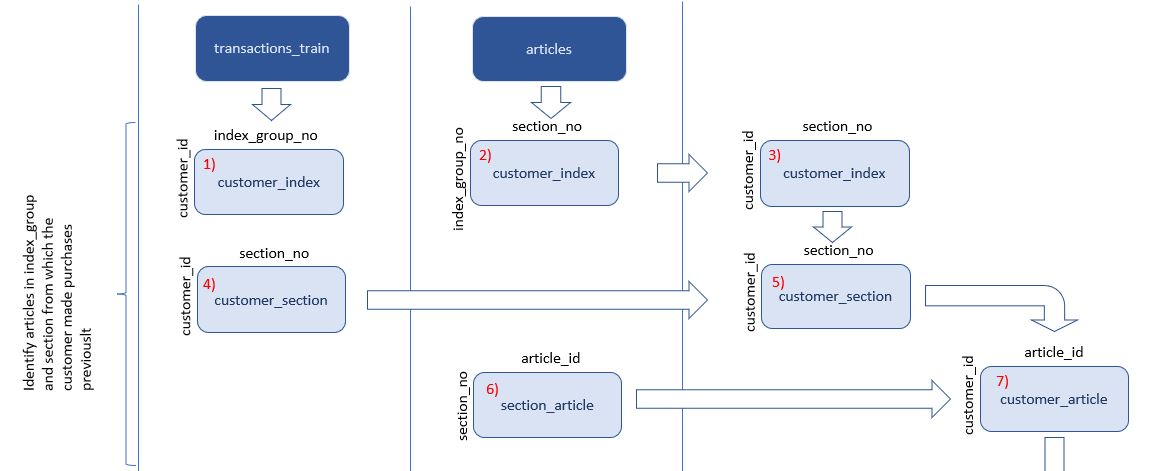

<b>2. Customers keep the same taste </b> <br>
<u>Reasoning:</u> If customer previously bought clothers in white, he/she will prefer the same colour / pattern for their next purchase <br>
<u>Implementation:</u> Using matrix factorization I filter articles according customer colour and pattern preference


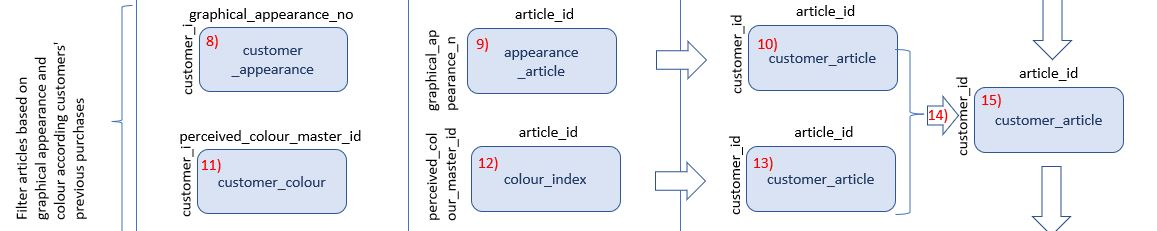

<b>3. Newer articles should be promoted </b> <br>
<u>Reasoning:</u> Fasion changes, so the company releases new products to attract customers. I assume H&M targets to attract customers with the new articles. <br>
<u>Implementation:</u> I assume the <i>article_id</i> is created subsequently for every new product. In other words, the higher <i>article_id</i> the newer article. Therefore I use the first 2 digits of <i>article_id</i> as a factor to identify new products.


In [ ]:
plt.figure(figsize=(20,3))
plt.scatter(transactions.groupby('article_id_2digit', as_index=False).t_dat.min()['article_id_2digit'], transactions.groupby('article_id_2digit', as_index=False).t_dat.min()['t_dat'])
plt.xticks(ticks=[x/100 for x in range(10, 100, 5)], labels=[l for l in range(10,100,5)])
plt.xlabel('First 2 digits of article_id')
plt.ylabel('First date the article was purchased')
plt.title('Article_id (first 2 digits) vs first date the article was bought')
plt.text(0.65, 18350, 'Higher article_id -> newer product', fontsize=16, c='red')
plt.show()

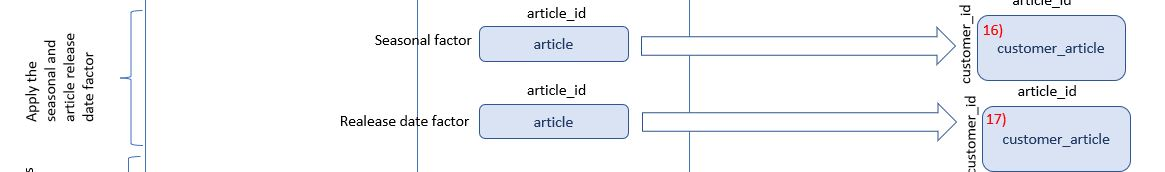

<b>4. Fasion is seasonable</b> <br>
<u>Reasoning:</u> People wear different clothes depending on the season: dresses in summer, jackets in winter, etc <br>
<u>Implementation:</u> The latest recorded transaction date is end of September. I target to recommend articles popular in October. Therefore, I check in transactions which articles have significantly higher sales in October and assign higher seasonality factor to them <br>

In [ ]:
articles_seasonality = transactions.groupby(['product_type_no', 'month'], as_index=False).article_id.count()
fig, axs = plt.subplots(1,3, figsize=(20,4))
type_no1 = 1
axs[0].bar(articles_seasonality[articles_seasonality['product_type_no'] == type_no1].month, articles_seasonality[articles_seasonality['product_type_no'] == type_no1].article_id)
axs[0].set_title('Article with high sales in October')
type_no2 = 2
axs[1].bar(articles_seasonality[articles_seasonality['product_type_no'] == type_no2].month, articles_seasonality[articles_seasonality['product_type_no'] == type_no2].article_id)
axs[1].set_title('Article with low sales in October')
type_no3 = 12
axs[2].bar(articles_seasonality[articles_seasonality['product_type_no'] == type_no3].month, articles_seasonality[articles_seasonality['product_type_no'] == type_no3].article_id)
axs[2].set_title('Article with relativel stable sales')

for ax in axs.flat:
    ax.set(xlabel='Months', ylabel='Sales')

In [ ]:
def score_seasonality(sales, month=10):
    if sales[month] >= sales.mean() * 1.5:
        return 1.1
    elif (sales[month] < sales.mean() * 1.5) & (sales[month] > sales.mean()):
        return 1
    elif (sales[month] < sales.mean()) & (sales[month] >= sales.mean() * 0.5):
        return 0.9
    else:
        return 0.8
articles_seasonality_pivot = pd.pivot_table(articles_seasonality, values='article_id', index='product_type_no', columns='month', aggfunc='sum', fill_value=0)
articles_seasonality_pivot['seasonal_factor'] = articles_seasonality_pivot.apply(score_seasonality, axis=1)
articles_seasonality_pivot.reset_index(inplace=True)
articles = articles.merge(articles_seasonality_pivot[['product_type_no', 'seasonal_factor']], on='product_type_no', how='left')
articles.loc[articles['seasonal_factor'].isna(), 'seasonal_factor'] = 1

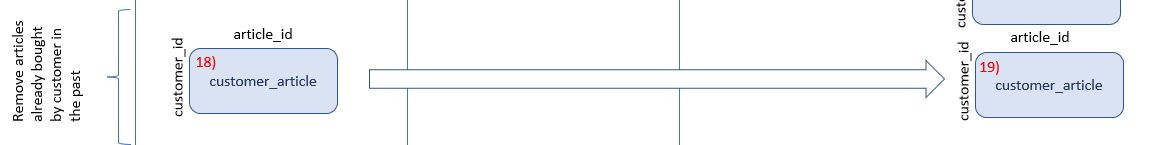

Below code summarizes the logic

In [ ]:
transactions_original = transactions.copy()

#Create a dataframe to collect prediction for all groups
total_recommendation = pd.DataFrame(columns=['customer_id', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12'])

#To reduce the size of the matrix I iterate through the customers in groups of size 10000 customers
#The number of customers to calculate in each iteration
group_size = 10000
#How many iterations
number_iterations = ceil(customers['customer_id'].max() / group_size)

for i in range(number_iterations):
    #Filter the transactions for the customer 
    transactions = transactions_original[transactions_original['customer_id'].isin(range(i*group_size, (i+1)*group_size))]
    
    #Encode customer_ids to reduce the matrix size
    le_customer_id2 = preprocessing.LabelEncoder()
    transactions['customer_id'] = le_customer_id2.fit_transform(transactions['customer_id'])
    
    #Add dummy row to allign number of features in transactions and articles dataframes
    if (transactions['product_code'].max() < articles['product_code'].max()) | (transactions['product_type_no'].max() < articles['product_type_no'].max()) | (transactions['graphical_appearance_no'].max() < articles['graphical_appearance_no'].max()) | (transactions['perceived_colour_master_id'].max() < articles['perceived_colour_master_id'].max()) | (transactions['index_group_no'].max() < articles['index_group_no'].max()) | (transactions['section_no'].max() < articles['section_no'].max()) | (transactions['article_id'].max() < articles['article_id'].max()):
        transactions = transactions.append(pd.DataFrame({'t_dat':transactions['t_dat'].max(),
                                                         'customer_id':transactions['customer_id'].max(),
                                                         'article_id':articles['article_id'].max(),
                                                         'article_id_2digit':articles['article_id_2digit'].max(),
                                                         'product_code':articles['product_code'].max(),
                                                         'product_type_no':articles['product_type_no'].max(),
                                                         'graphical_appearance_no':articles['graphical_appearance_no'].max(),
                                                         'perceived_colour_master_id':articles['perceived_colour_master_id'].max(),
                                                         'index_group_no':articles['index_group_no'].max(),
                                                         'section_no':articles['section_no'].max(),
                                                         'month':transactions['month'],
                                                         'week':transactions['week'],
                                                         'item':0}, index = [0]), ignore_index=True)
        
    #Identify indexgroup / sections from which the customers purchased articles
    #Each index group and section gets score depending on how may articles the customers bought articles from
    #Detail to article_id level
    #1) Construct a matrix of customer_id - index_group_no
    customer_indexgroup = coo_matrix((transactions['item'], (transactions['customer_id'], transactions['index_group_no'])))
    #2) Construct a matrix of products index_group - section
    indexgroup_section = coo_matrix((articles['item'], (articles['index_group_no'], articles['section_no'])))
    indexgroup_section_csr = indexgroup_section.tocsr()
    indexgroup_section_csr[indexgroup_section_csr > 0] = 1
    #3) Construct a matrix of customer purchases - customer_id per section_no
    customer_section = customer_indexgroup.dot(indexgroup_section_csr)
    #4) Construct a matrix of customer_id per section_no
    customer_section2 = coo_matrix((transactions['item'], (transactions['customer_id'], transactions['section_no'])))
    #5) Combine the two matrix
    customer_section = customer_section + customer_section2
    #6) Construct a matrix of section_no per article_id
    section_article = coo_matrix((articles['item'], (articles['section_no'], articles['article_id'])))
    section_article_csr = section_article.tocsr()
    section_article_csr[section_article_csr > 0] = 1
    #7) Construct a matrix of customer_id and article
    customer_article = customer_section.dot(section_article_csr)
    
    #Apply customer appearance and colour preferences
    #8) Construct a matrix customer_id appearance
    customer_appearance = coo_matrix((transactions['item'], (transactions['customer_id'], transactions['graphical_appearance_no'])))
    #9) Construct a matrix appearance - article_id
    appearance_article = coo_matrix((articles['item'], (articles['graphical_appearance_no'], articles['article_id'])))
    #10) Combine to obtain customer - article_id matrix
    customer_article_appearance = customer_appearance.dot(appearance_article)
    #11) Construct a matrix customer_id - colour
    customer_colour = coo_matrix((transactions['item'], (transactions['customer_id'], transactions['perceived_colour_master_id'])))
    #12) Construct a matrix colour - article_id
    colour_article = coo_matrix((articles['item'], (articles['perceived_colour_master_id'], articles['article_id'])))
    #13) Combine to obrain customer_id - colour
    customer_article_colour = customer_colour.dot(colour_article)
    #14) Combine apperance and colour
    customer_article_appearance = customer_article_appearance.multiply(customer_article_colour)
    #15) Apply to customer_id - article_id matrix
    customer_article = customer_article.multiply(customer_article_appearance)
    
    #16) Apply the seasonality factor
    customer_article = customer_article.multiply(articles['seasonal_factor'].values)
    #17) Apply the release date factor
    customer_article = customer_article.multiply(articles['article_id_2digit'].values)
    
    #18) Remove the article already bought by the customer
    customer_bought = coo_matrix((transactions['item'], (transactions['customer_id'], transactions['article_id'])))
    customer_bought = customer_bought * 100000
    #19)
    customer_article = customer_article - customer_bought
    
    #Identify the top scored articles for every customer_id
    top_recommendations = []
    while len(top_recommendations) < 12:
        #Identify the highest score for each customer
        top_temp = customer_article.argmax(1).reshape(-1).tolist()[0]
        top_recommendations.append(top_temp)
        #Remove the top recommendations
        if max(top_temp) < customer_article.get_shape()[1]:
            del_max = coo_matrix(([200000]*len(top_temp) + [0], ([i for i in range(len(top_temp))] + [len(top_temp)-1], top_temp + [customer_article.get_shape()[1]-1])))
        else:
            del_max = coo_matrix(([200000]*len(top_temp), ([i for i in range(len(top_temp))], top_temp)))
        customer_article = customer_article - del_max

    #Sumarize the recommendation in a dataframe
    result_df = pd.DataFrame({'customer_id':[j for j in range(customer_article.get_shape()[0])],
                          'r1':top_recommendations[0],
                          'r2':top_recommendations[1],
                          'r3':top_recommendations[2],
                          'r4':top_recommendations[3],
                          'r5':top_recommendations[4],
                          'r6':top_recommendations[5],
                          'r7':top_recommendations[6],
                          'r8':top_recommendations[7],
                          'r9':top_recommendations[8],
                          'r10':top_recommendations[9],
                          'r11':top_recommendations[10],
                          'r12':top_recommendations[11]})
    
    #Convert back to the original customer_id coding
    result_df['customer_id'] = le_customer_id2.inverse_transform(result_df['customer_id'])
    
    total_recommendation = total_recommendation.append(result_df[['customer_id', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12']], ignore_index=True)

I do not include the rest of the code as the main purpose of the notebook was to share the logic. <br><br>
<u> Final comments </u>
<ul>
    <li>The customers who have not made any purchase - group customers by age and recommend highest scored articles for each age group</li>
    <li>Consideration for next steps:</li>
    <ul>
        <li>I used <i>index_group_no</i> and <i>section_no</i> to identify customer previous purchases. Experiment with other features like <i>department_code</i></li>
        <li>Use only the latest purchase by the customer</li>
        <li>Change the seasonality factor</li>
    </ul>
</ul>
